# Parsing glaucoma data

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.

Run this notebook to process data (mainly from UKBB and CLSA, although the process may be altered for other datasets)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pickle as pkl
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string
from glaucoma.helpers.glaucoma_helpers import is_number, parse_files, return_uniq_index, return_duplicates, plot_idx, split_unzipped

## Set directories to use

In [15]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR /"train"

In [21]:
## Unzip files if they are zipped

In [19]:
zipped_files = parse_files(str(DATA_DIR / "zipped"))

In [8]:
# unzip all data files
for f in zipped_files:
    print(str(f))
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall(str(DATA_DIR / "unzipped"))
        

In [ ]:
import os
import sys
import string
import shutil

#Generate the file paths to traverse, or a single path if a file name was given
def getfiles(path):
    if os.path.isdir(path):
        for root, dirs, files in os.walk(path):
            for name in files:
                yield os.path.join(root, name)
    else:
        yield path

destination = str(DATA_DIR / "images") 
fromdir = DATA_DIR / "unzipped"
for f in getfiles(fromdir):
    filename = string.split(f, '/')[-1]
    if os.path.isfile(destination+filename):
        filename = f.replace(fromdir,"",1).replace("/","_")
    #os.rename(f, destination+filename)
    shutil.copy(f, destination+filename)

Parsing the metafiles, V1 refers to VCDR measurements, while V2 refers to Diameter measurements

In [13]:
meta_files = parse_files(str(META_DIR))
v1_meta =[i for i in meta_files if not "V2" in i]
v2_meta = [i for i in meta_files if "V2" in i]

In [15]:
meta_df_list =[]
for meta in v1_meta:
    df = pd.read_csv(meta,sep = '\t',header = None,names = [ "file_name","assesment"])
    df['batch_name'] = os.path.split(meta)[1].split(".")[0]
    meta_df_list.append(df)


In [16]:
meta_v2_df_list =[]
for meta in v2_meta:
    df = pd.read_csv(meta,sep = '\t',header = None,names = [ "file_name","area","col1","col2"])
    df['batch_name'] = os.path.split(meta)[1].split(".")[0]
    meta_v2_df_list.append(df)

In [19]:
meta_df = pd.concat(meta_df_list,ignore_index =True)

In [20]:
meta_v2_df = pd.concat(meta_v2_df_list,ignore_index =True)

In [21]:
#split up assesment for easy reading
meta_df[['additional','grading']] = meta_df['assesment'].str.extract('([A-Za-z]+)(\d+\.?\d*)', expand = True)

In [30]:
#store all meta_df grading info
assesments = list(meta_df["assesment"])

In [31]:
# check non na entries
meta_df = meta_df[meta_df['assesment'].notna()]

In [32]:
meta_df.loc[meta_df['grading'].isnull(),"grading"] = meta_df.loc[meta_df['grading'].isnull(),"assesment"]

In [33]:
# take out the string values (corresonding to ungradable images) and replacing them to -1 
for i,item in enumerate(assesments):
    if any(map(str.isdigit, item)) == False:
        meta_df.iloc[i,4] = -1
        meta_df.iloc[i,3] = meta_df.iloc[i,1]

Save out metafiles after they have been processed

In [85]:
#pkl.dump(meta_df,open(str(DATA_DIR /"meta_df_v5.pkl"),'wb'))
#pkl.dump(graded_df,open(str(DATA_DIR /"graded_df_v1.pkl"),'wb'))

## Parsing the multiple files

In [35]:
meta_df.drop_duplicates(subset = ['file_name','assesment'], inplace= True)

In [36]:
meta_df.shape

(90957, 5)

In [37]:
#groupby each filename, if there are multiples
image_grouby = meta_df.groupby("file_name")["grading"]

In [38]:
#cast as float
meta_df["grading"] = meta_df["grading"].astype('float')

In [39]:
image_grouby = meta_df.groupby("file_name")["grading"].agg(['mean','count',"var"])

In [ ]:
image_grouby[(image_grouby["var"] > 0)]

In [41]:
grouped_meta = meta_df.groupby("file_name")

In [45]:
#count the number of gradings for each model
meta_df["grading"].value_counts()

-1.00     15239
 3.00     11744
 3.50      8622
 2.50      7555
 4.00      6983
 2.00      5130
 4.50      4595
 1.50      4273
 5.50      4141
 0.50      3986
 1.00      3694
 5.00      3692
 0.00      2720
 6.00      2489
 6.50      1963
 7.00      1659
 7.50      1439
 8.00       554
 8.50       279
 9.00       133
 9.50        56
 7.57         4
 2.52         2
 6.57         1
 76.50        1
 6.55         1
 77.50        1
 6.56         1
Name: grading, dtype: int64

Here we see some "faulty" gradings that should be rectified

In [46]:
# stats for gradable results
graded_df = meta_df[meta_df["grading"] != -1]
graded_groupby = graded_df.groupby("file_name")["grading"].agg(['mean','count',"var"])
graded_groupby[(graded_groupby["count"] > 1)].index

Index(['1002488_21015_0_0.jpg', '1004351_21015_0_0.jpg',
       '1006584_21015_1_0.jpg', '1009215_21015_1_0.jpg',
       '1012283_21015_0_0.jpg', '1012340_21015_1_0.jpg',
       '1012577_21015_0_0.jpg', '1013136_21015_0_0.jpg',
       '1015159_21015_1_0.jpg', '1018891_21015_0_0.jpg',
       ...
       '85186631_21015_0_0.jpg', '85216010_21015_0_0.jpg',
       '85412352_21015_0_0.jpg', '85488404_21015_0_0.jpg',
       '85581305_21015_0_0.jpg', '85661531_21015_0_0.jpg',
       '85728466_21015_0_0.jpg', '85778272_21015_0_0.jpg',
       '85953539_21015_0_0.jpg', '85960274_21015_0_0.jpg'],
      dtype='object', name='file_name', length=3486)

In [47]:
high_count_diff_var = list(set(graded_groupby[(graded_groupby["count"] > 1)].index) - set(graded_groupby[(graded_groupby["var"] > 0)].index))
graded_df[graded_df['file_name'] == high_count_diff_var[18]]

,file_name,assesment,batch_name,additional,grading
32973,3522988_21015_1_0.jpg,D3.5,L_88_NickAndrew,D,3.5
96764,3522988_21015_1_0.jpg,3.5,L_88_alexhewitt,NaN,3.5


## Plot the distributions of gradings 

<AxesSubplot:xlabel='grading', ylabel='count'>

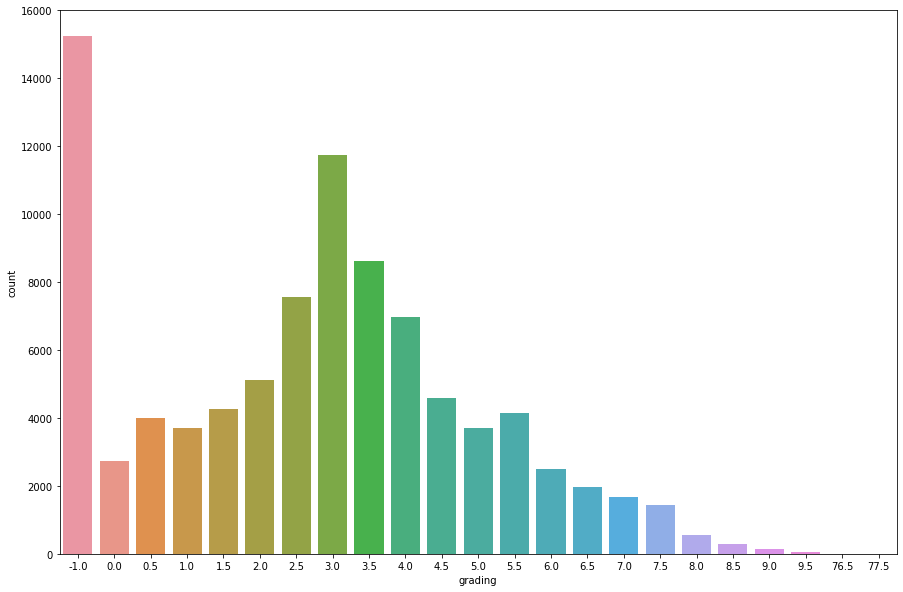

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x='grading', data=meta_df[meta_df["grading"] % 0.5 == 0],ax = ax)


## Regraded samples

This deals with samples which have multiple gradings present in the dataset

In [51]:
meta_df = pkl.load(open(DATA_DIR/ "meta_df_v5.pkl","rb"))

In [ ]:
#samples which contain an intial no grading, and then are regreaded should be listed, as they probably represent more "noisy" samples. need to figure out how to group

In [138]:
#samples with more than one count:
multi_sample_meta = list(set(image_grouby[(image_grouby["count"] > 1)].index))

In [170]:
len(graded_df["file_name"].unique())

72142

In [192]:
# find all the regraded sampels
regraded_samples = []
additional_regraded =0
regraded_duplicates = []
for file in multi_sample_meta:
    #pull up the df entry
    df = meta_df[meta_df["file_name"] == file]
    if -1. in df['grading'].unique() and len(df['grading'].unique()) > 1:
        regraded_samples.append(file)
        regraded_duplicates.append([file,len(df["file_name"])])
        #additional_regraded += len(df['grading'].unique()) -2

In [189]:
len(regraded_samples)

3373

In [176]:
meta_df[meta_df["file_name"] == regraded_samples[0]]

,file_name,assesment,additional,grading,batch_name
5542,2494677_21015_0_0.jpg,8,NaN,8.0,L_A_jamie1
62652,2494677_21015_0_0.jpg,4,NaN,4.0,L_A_alexhewitt


In [178]:
len(meta_df["file_name"].unique())

84810

In [61]:
unzipped_files = parse_files(str(DATA_DIR / "unzipped"))

In [62]:
# split up unzipped files
unzipped_head, unzipped_tail = split_unzipped(unzipped_files)

In [206]:
uniq_idx = return_uniq_index(unzipped_tail)

In [20]:
meta_df.drop_duplicates(inplace = True)

In [208]:
len(meta_df) -len(meta_df["file_name"].unique())

6147

In [214]:
duplicate_dict = sorted(list_duplicates(unzipped_tail))

In [61]:
ungraded_images = len((set(unzipped_tail) - set(meta_df["file_name"].unique())) - set(meta_v2_df["file_name"].unique()))

In [34]:
unzipped_tail.index(gluacoma_files[1])

63405

In [82]:
destination = str(DATA_DIR / "subset")
for file in non_glauc_files:
    #search through unzipped
    idx = unzipped_tail.index(file)
    file_loc = unzipped_head[idx] +"/"+ file
    shutil.copy2(file_loc,destination)
    #move file to subset
    
    

In [227]:
import shutil
import matplotlib.image as mpimg


In [211]:
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)



In [217]:
unzipped_head[8734],unzipped_head[86253]

('/home/kaiah_steven_maxkelsen_com/glaucoma/data/unzipped/L_94Left',
 '/home/kaiah_steven_maxkelsen_com/glaucoma/data/unzipped/L_84')

## Exploring dataset

In [ ]:
plot_idx(49294)
plot_idx(59465)

In [247]:
meta_df["batch"] = "/"

In [ ]:
#adding batch;s to the df
for file in list(meta_df["file_name"]):

In [ ]:
for file in list(meta_df["file_name"]):
    #find first index of array:
    idx = unzipped_tail.index(file)
    

In [274]:
meta_df[meta_df['file_name'] == '1775057_21015_0_0.jpg']

,file_name,assesment,grading,additional,batch
17548,1775057_21015_0_0.jpg,X,-1,X,/
65182,1775057_21015_0_0.jpg,2,2,NaN,/


In [215]:
for dup in sorted(list_duplicates(unzipped_tail)):
    print(dup)
    

('1000534_21015_1_0.jpg', [8734, 86253])
('1000534_21016_1_0.jpg', [53416, 78098, 79541])
('1001461_21015_1_0.jpg', [8014, 10430])
('1001461_21016_1_0.jpg', [77713, 79332])
('1002350_21015_0_0.jpg', [49294, 59465])
('1002421_21015_0_0.jpg', [16152, 73823])
('1003720_21015_0_0.jpg', [29562, 39073, 55746])
('1003720_21016_0_0.jpg', [62148, 97519])
('1003909_21015_0_0.jpg', [16230, 73901])
('1003934_21015_1_0.jpg', [7934, 53485, 81683])
('1003934_21016_1_0.jpg', [78879, 80029])
('1004150_21015_0_0.jpg', [49065, 59235])
('1004783_21016_0_0.jpg', [66311, 85059])
('1005114_21015_0_0.jpg', [13859, 39983])
('1005236_21015_0_0.jpg', [13853, 39977])
('1005656_21015_0_0.jpg', [44069, 88625])
('1006003_21016_1_0.jpg', [53957, 82270])
('1006872_21015_0_0.jpg', [16533, 74202])
('1007163_21015_0_0.jpg', [49123, 59293])
('1007311_21015_1_0.jpg', [8394, 10616])
('1007311_21016_1_0.jpg', [79027, 80109])
('1007886_21015_0_0.jpg', [30107, 32152, 56643])
('1007886_21016_0_0.jpg', [53802, 62017, 97305])
('1

In [ ]:
plot_idx(6439)

In [ ]:
plot_idx(85559)

### plot samples from each grading class:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 3
fig = plt.figure(figsize=(25,20))
columns = 5
rows = 4

# prep (x,y) for extra plotting
#xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
#ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    f_name = list(meta_df[meta_df['grading'] == i/2]['file_name'])[10]
    idx = unzipped_tail.index(f_name)
    
    img=mpimg.imread(unzipped_files[idx])
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("rating:"+ str(i/2))  # set title
    plt.imshow(img, alpha=1)

# do extra plots on selected axes/subplots
# note: index starts with 0


plt.show()  # finally, render the plot
    

## image subsets of all ratings

In [55]:
meta_df["grading"].unique()

array([-1. ,  4.5,  7. ,  3. ,  3.5,  2.5,  4. ,  0.5,  9. ,  5. ,  7.5,
        1.5,  6. ,  8. ,  2. ,  6.5,  5.5,  0. ,  1. ,  9.5,  8.5])

In [56]:
list_of_rating = ['3', '7.5', '3.5', '4', '2', '1', '0', '0.5', '7', '2.5', '6',
       '5.5', '8.5', '4.5', '1.5', '6.5', '5', '8', '9.5', '9',]

In [58]:
import shutil

In [270]:
# moving images into label file structure
for rating in range(20):
    dir = str(RATING_SS_DIR/ str(rating))
    #pull out 120 files
    f_names = list(meta_df[meta_df['grading'] == str(rating)]['file_name'])[0:120]
    #pull out indexs
    for f in f_names:
        idx = unzipped_tail.index(f)
        shutil.copy2(unzipped_files[idx],dir)
    
    img=mpimg.imread(unzipped_files[idx])
   
    imgplot = plt.imshow(img)
    plt.show()
    
    

In [ ]:
#putting all data (copies and all) into folders
#this will have some noisy labels (see regraded samples)
for rating in range(20):
    os.mkdir(TRAIN_DIR /str(rating/2))
    dir = str(TRAIN_DIR / str(rating/2))
    f_names = list(meta_df[meta_df['grading'] == rating/2]['file_name'])
    for f in f_names:
        try:
            idx = unzipped_tail.index(f)
        except:
            print(f)
        shutil.copy2(unzipped_files[idx],dir)
    print(rating/2," " ,len(f_names))